In [ ]:
import torch
import numpy
import pandas as pd
import torch.nn.functional as F
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
import torch.utils.data as data
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

: 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 322
input_size = 13
num_classes = 2
learning_rate = 0.001
batch_size = 1
num_epochs = 200
torch.manual_seed(SEED)

In [2]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [3]:
class MyDataset(data.Dataset):
    def __init__(self, csv_path):
        self.dataset = pd.read_csv(csv_path)
        self.x = self.dataset.iloc[:,:-1].to_numpy()
        self.y = self.dataset.iloc[:,-1].to_numpy()
        self.x = torch.from_numpy(self.x)
        self.y = torch.from_numpy(self.y)


    def __getitem__(self, index):
        features, target = self.x[index], self.y[index]

        return features, target

    def __len__(self):
      return self.x.shape[0]

In [4]:
dataset = MyDataset("heart_cleveland_upload.csv")
train_dataset, test_dataset = random_split(dataset,(222, 75))

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x.float())
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct/num_samples

In [16]:
model = NN(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
# optimizer = optim.SGD(model.parameters(), nesterov=True, momentum=0.9, lr=0.1, weight_decay=0.0001)

train_acc = []
test_acc = []

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data.float())
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    train_acc.append(check_accuracy(train_loader, model))
    test_acc.append(check_accuracy(test_loader, model))


print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 86.94
Accuracy on test set: 80.00


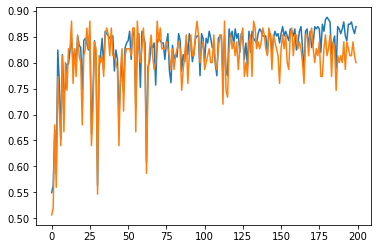

In [17]:
plt.plot(train_acc)
plt.plot(test_acc)